## ESM for extract embeddings features

In [3]:
#pip install fair-esm==2.0.0 --force-reinstall

In [4]:
# version of esm
%pip show fair-esm

Name: fair-esm
Version: 2.0.0
Summary: Evolutionary Scale Modeling (esm): Pretrained language models for proteins. From Facebook AI Research.
Home-page: https://github.com/facebookresearch/esm
Author: Facebook AI Research
Author-email: 
License: MIT
Location: /stor/home/alf3564/miniconda3/envs/esm/lib/python3.9/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import esm
import torch
import numpy as np
import pandas as pd

**Model esm1b_t33_650M_UR50S()**:   
SOTA general-purpose protein language model. Can be used to predict structure, function and other protein properties directly from individual sequences. Released with Rives et al. 2019 (Dec 2020 update).

**Model esm1v_t33_650M_UR90S_1()**:  
Language model specialized for prediction of variant effects. Enables SOTA zero-shot prediction of the functional effects of sequence variations. Same architecture as ESM-1b, but trained on UniRef90. Released with Meier et al. 2021.  


**esm2_t33_650M_UR50D()**  
SOTA general-purpose protein language model. Can be used to predict structure, function and other protein properties directly from individual sequences. Released with Lin et al. 2022 (Aug 2022 update).

All models are stored at:   
/stor/home/lcv454/.cache/torch/hub/checkpoints/

In [6]:
# Load ESM model

#model used on this exemple available on git, most recent version 
#model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

# to predict contact, I used this first
#model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

#examples/variant-prediction. 
#model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1() #warning, "Regression weights not found, predicting contacts will not produce correct results."
#model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S() == _1() 

batch_converter = alphabet.get_batch_converter()

# disables dropout for deterministic results
model.eval()  

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (

In [1]:
data = pd.read_csv('data/oral_pathogens.csv')


# data = data.rename(columns={'Peptide': 'ID'})

# data = pd.read_excel('data/AMP_peptides_DBAASP_selected_to_test.xlsx')
# data = data.rename(columns={'SEQUENCE': 'Sequence'})

data

NameError: name 'pd' is not defined

In [8]:
# preparing the data
sequences = [(x,y) for x,y in zip(data['ID'], data['Sequence'])]

batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

In [9]:
%%time
#repr_layers MUST be changed to match the model!!!

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (ids, seq) in enumerate(sequences):
    sequence_representations.append([ids, token_representations[i, 1 : len(seq) + 1].mean(0)])

    
sequence_representations[:5]

CPU times: user 1min 1s, sys: 35.1 s, total: 1min 36s
Wall time: 1.73 s


[['Treponema_denticola/refseq/bacteria/GCF_024181465.1/GCF_024181465.1_ASM2418146v1_genomic|NZ_CP051522.1|461956:462090:1',
  tensor([-1.2369e-01, -1.5099e-01,  3.2845e-01,  2.8946e-01,  1.4413e-01,
          -6.8260e-02, -5.1784e-02, -1.9368e-02, -9.8407e-03, -1.0763e-01,
          -3.0515e-02,  1.6563e-01, -1.7827e-01,  1.2659e-01,  1.5076e-01,
          -2.4835e-02,  2.7256e-01, -1.1899e-01,  5.6657e-02,  1.7213e-01,
           1.0047e-01, -8.1935e-02,  4.0100e-02, -2.0969e-01, -7.7037e-03,
           2.2252e-01, -1.0796e-01,  1.6607e-01,  1.3097e-01, -1.0032e-01,
          -1.6664e-01,  5.2356e-01,  2.3861e-01,  1.1622e-01,  9.4995e-03,
          -1.6521e-01,  9.7031e-02, -8.7624e-03,  2.3345e-01,  2.8338e-01,
           7.1677e-02,  3.2852e-01, -3.0516e-01,  6.4611e-02,  5.4251e-02,
          -4.3653e-03, -1.0303e+00,  2.1763e-01, -1.1772e-01, -1.6288e-02,
           5.8851e-02,  7.2797e-03,  1.6111e-01,  3.1553e-02,  7.0913e-02,
          -1.4907e-01,  2.2921e-01,  5.1582e-02,  8

In [10]:
# get embeddings
embedings = []
for x in sequence_representations:
    emb = x[1].tolist()
    emb.insert(0, x[0])
    embedings.append(emb)

print(embedings[0][:5], len(embedings[0]))

['Treponema_denticola/refseq/bacteria/GCF_024181465.1/GCF_024181465.1_ASM2418146v1_genomic|NZ_CP051522.1|461956:462090:1', -0.12369158118963242, -0.15098978579044342, 0.328445166349411, 0.2894635796546936] 321


In [11]:
df = pd.DataFrame(embedings)
df

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,Treponema_denticola/refseq/bacteria/GCF_024181...,-0.123692,-0.150990,0.328445,0.289464,0.144126,-0.068260,-0.051784,-0.019368,-0.009841,...,0.112277,0.067314,-0.089984,0.054641,0.182882,-0.143182,-0.225901,0.105448,0.119691,0.053044
1,Treponema_denticola/refseq/bacteria/GCF_024181...,-0.123692,-0.150990,0.328445,0.289464,0.144126,-0.068260,-0.051784,-0.019368,-0.009841,...,0.112277,0.067314,-0.089984,0.054641,0.182882,-0.143182,-0.225901,0.105448,0.119691,0.053044
2,Treponema_denticola/refseq/bacteria/GCF_000338...,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,0.007988,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
3,Treponema_denticola/refseq/bacteria/GCF_000413...,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,0.007988,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
4,Treponema_denticola/refseq/bacteria/GCF_000413...,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,0.007988,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,-0.043348,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
63,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,-0.043348,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
64,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,-0.043348,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
65,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,-0.043348,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098


In [12]:
df = df.rename(columns={0:'ID'})
esm_embeddings = pd.merge(data, df, how='left', left_on='ID', right_on='ID')
esm_embeddings

,ID,Sequence,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,320
0,Treponema_denticola/refseq/bacteria/GCF_024181...,MKNKGLYRKLSISELKNIFGGEMLDDQGRKIVRKNLDGVYSIKD,-0.123692,-0.150990,0.328445,0.289464,0.144126,-0.068260,-0.051784,-0.019368,...,0.112277,0.067314,-0.089984,0.054641,0.182882,-0.143182,-0.225901,0.105448,0.119691,0.053044
1,Treponema_denticola/refseq/bacteria/GCF_024181...,MKNKGLYRKLSISELKNIFGGEMLDDQGRKIVRKNLDGVYSIKD,-0.123692,-0.150990,0.328445,0.289464,0.144126,-0.068260,-0.051784,-0.019368,...,0.112277,0.067314,-0.089984,0.054641,0.182882,-0.143182,-0.225901,0.105448,0.119691,0.053044
2,Treponema_denticola/refseq/bacteria/GCF_000338...,MKNKGLYIKLSISELKNIFGGEMLDDQGRKIVRKNLDGVYSIKD,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
3,Treponema_denticola/refseq/bacteria/GCF_000413...,MKNKGLYIKLSISELKNIFGGEMLDDQGRKIVRKNLDGVYSIKD,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
4,Treponema_denticola/refseq/bacteria/GCF_000413...,MKNKGLYIKLSISELKNIFGGEMLDDQGRKIVRKNLDGVYSIKD,-0.092535,-0.162749,0.311859,0.250543,0.154550,-0.074600,-0.049799,-0.021462,...,0.124502,0.075756,-0.085404,0.042107,0.193607,-0.151499,-0.256006,0.069185,0.142028,0.053606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,MKKIKFEKLSQDEMKMISGGADPLQPELGGVCKPLATPSQCSGKCS...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
63,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,MKKIKFEKLSQDEMKMISGGADPLQPELGGVCKPLATPSQCSGKCS...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
64,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,MKKIKFEKLSQDEMKMISGGADPLQPELGGVCKPLATPSQCSGKCS...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098
65,Porphyromonas_gingivalis/refseq/bacteria/GCF_0...,MKKIKFEKLSQDEMKMISGGADPLQPELGGVCKPLATPSQCSGKCS...,0.045436,0.009262,0.197697,0.209979,0.053508,0.096826,-0.262374,-0.205863,...,0.082445,0.090558,-0.093445,0.077056,-0.045321,-0.195983,-0.208204,0.014518,-0.008930,0.023098


In [13]:
#esm_embeddings.to_csv('data/CSV_OUTPUT_HERE.csv')


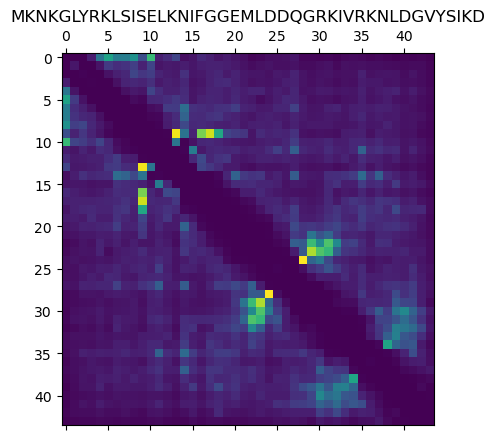

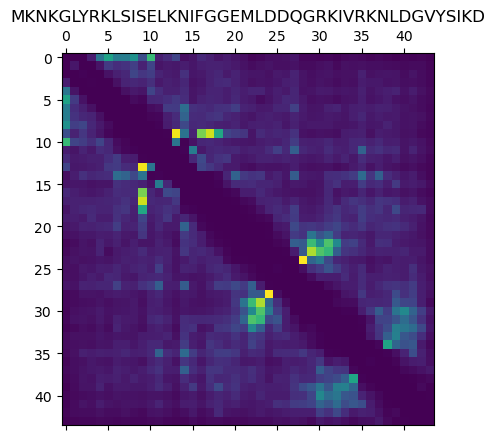

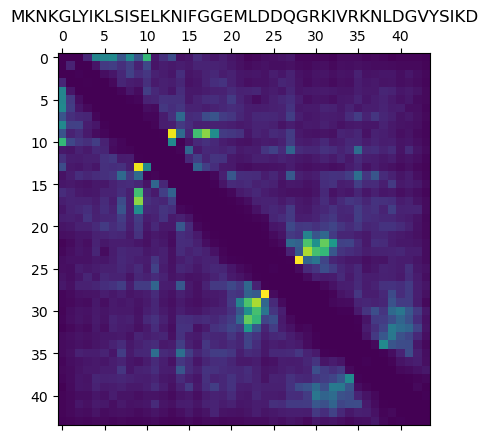

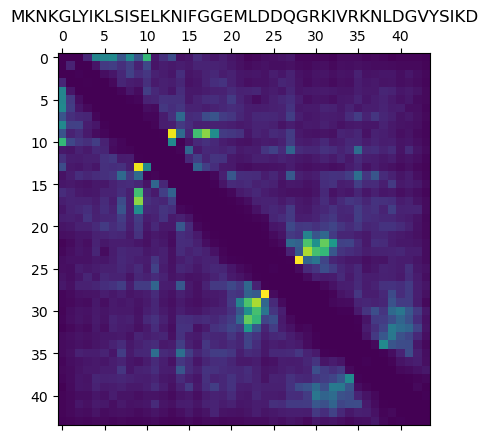

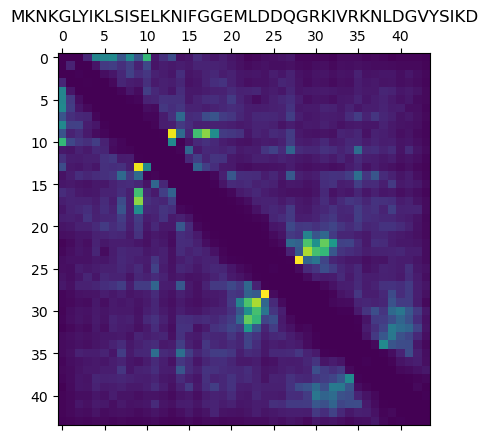

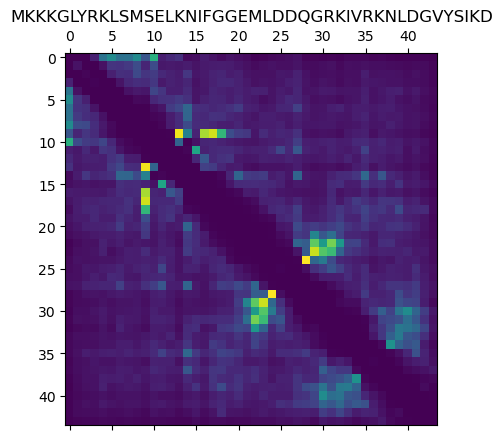

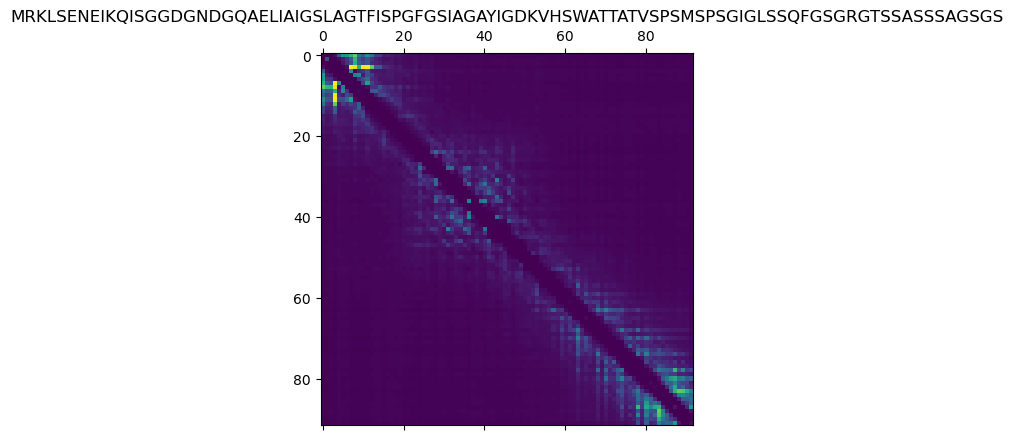

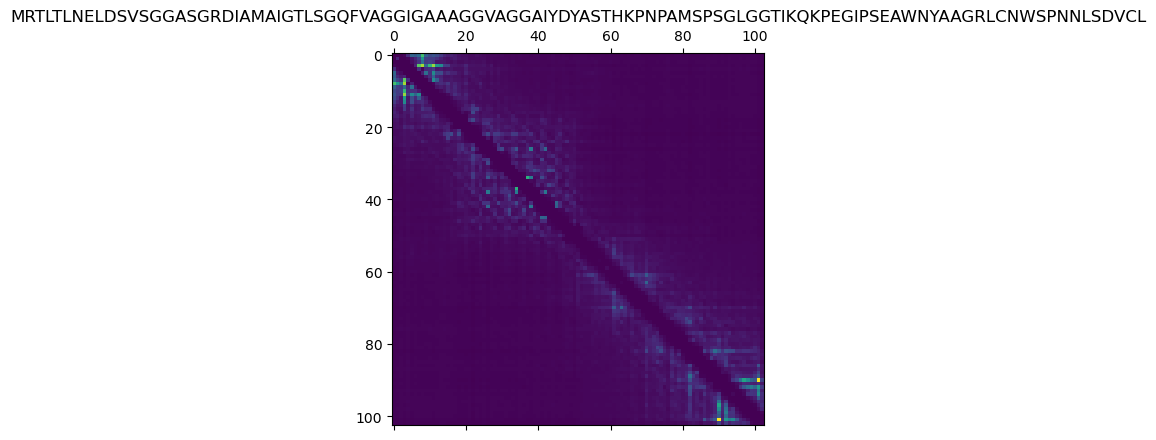

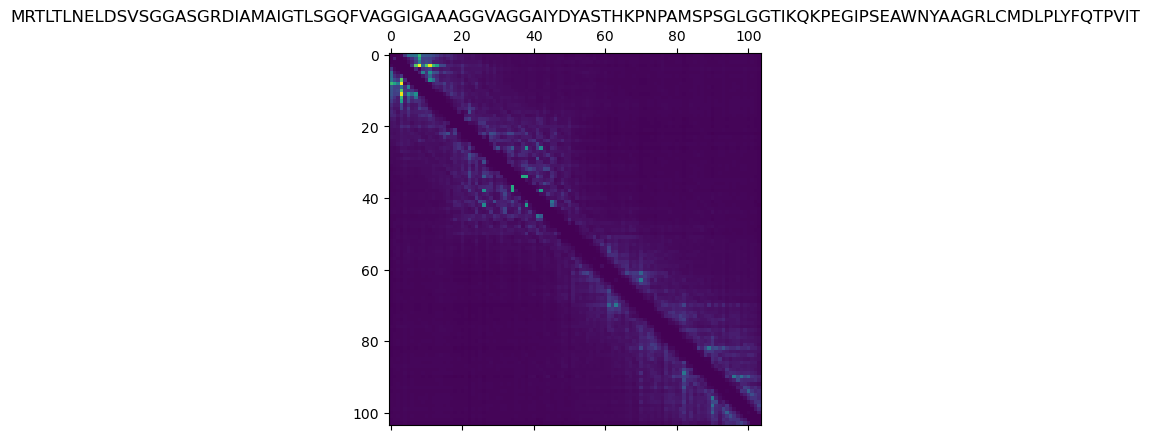

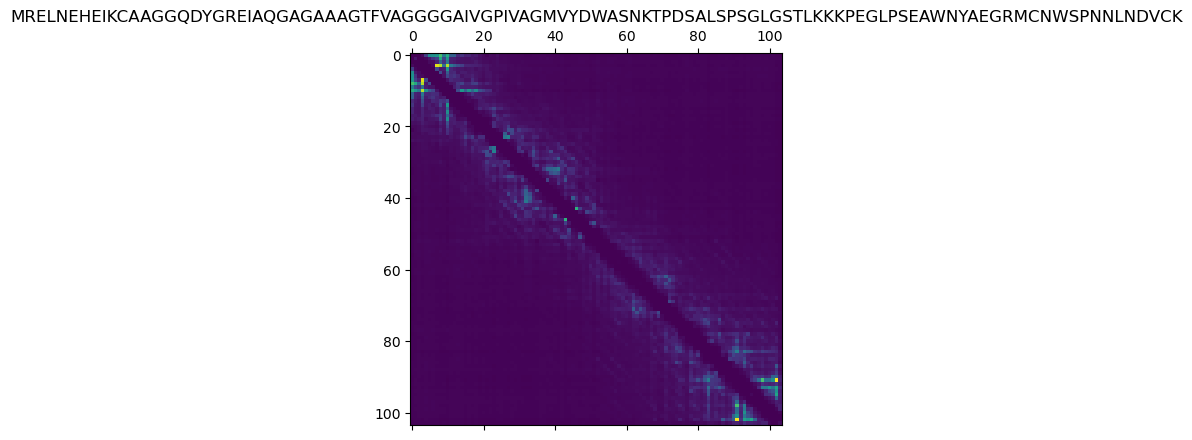

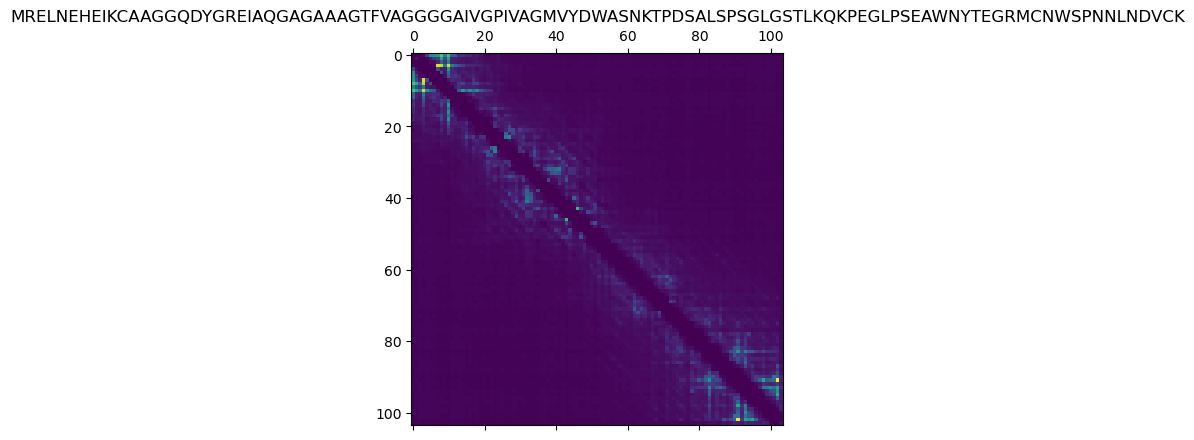

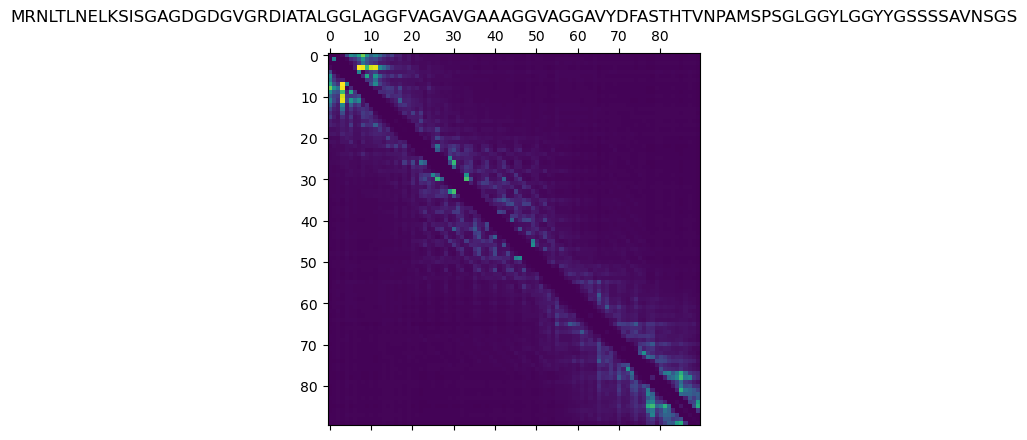

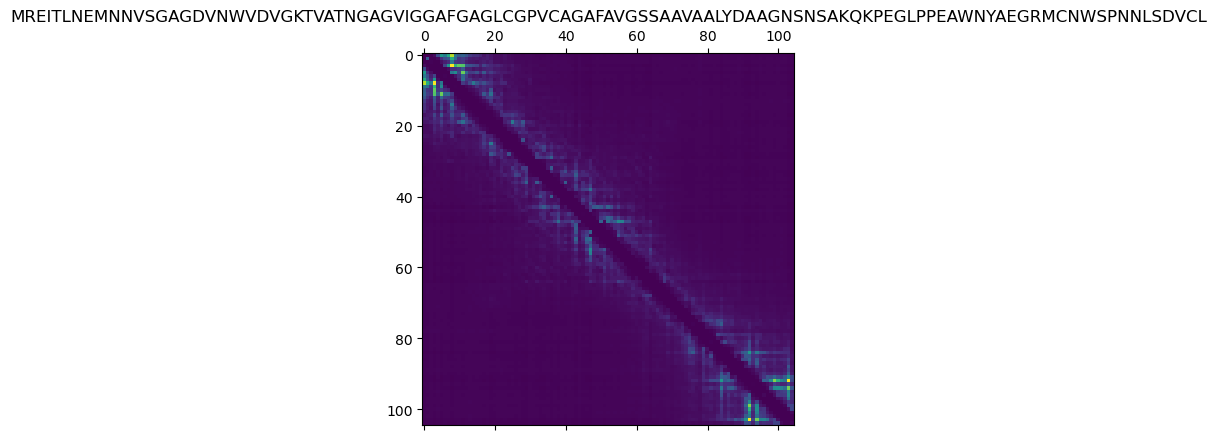

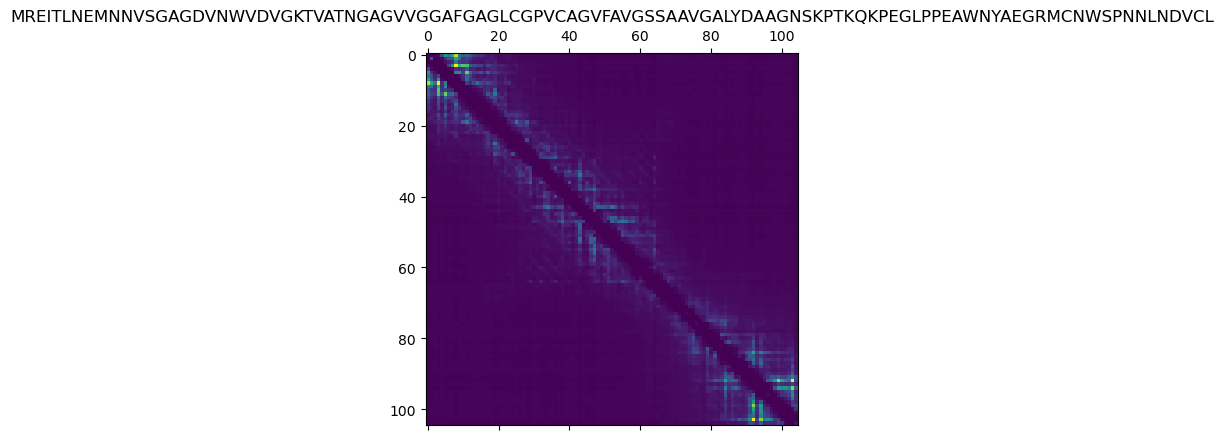

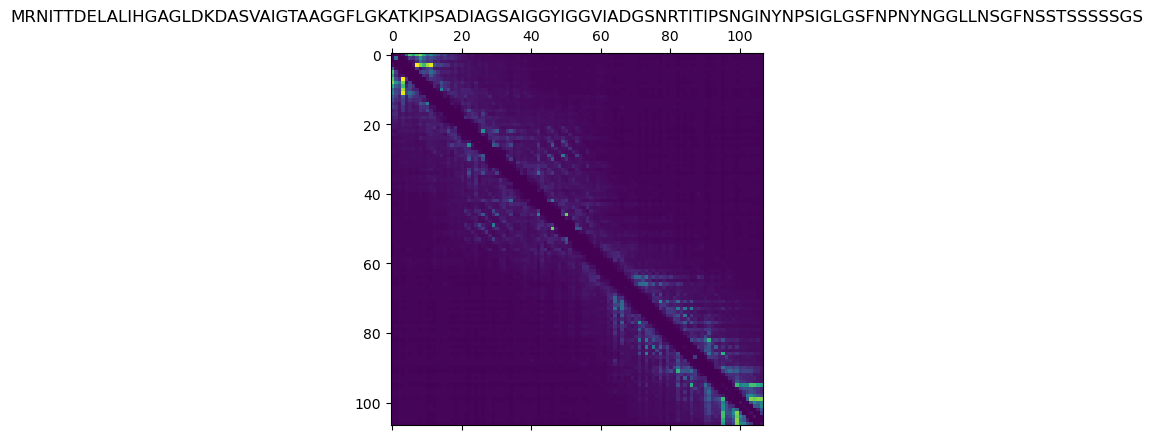

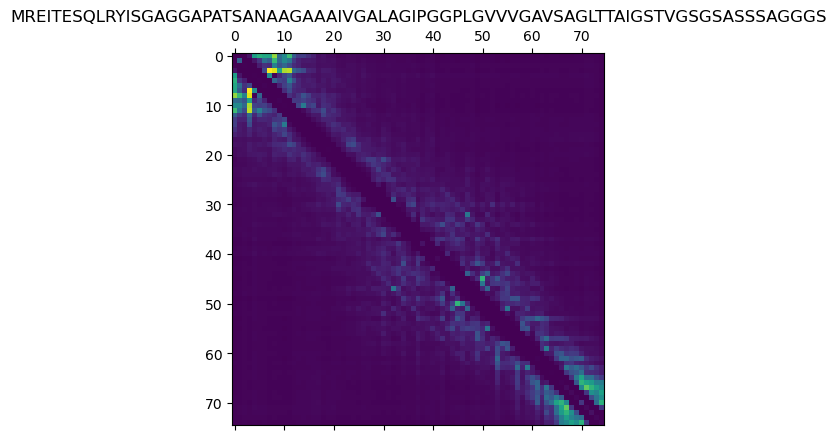

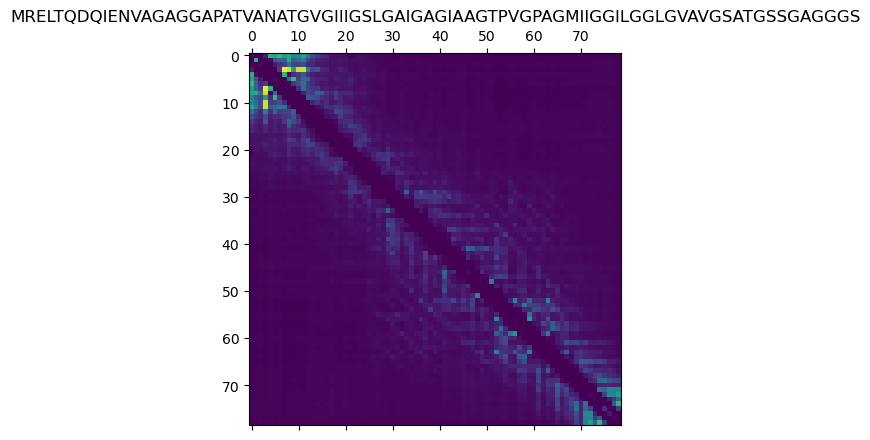

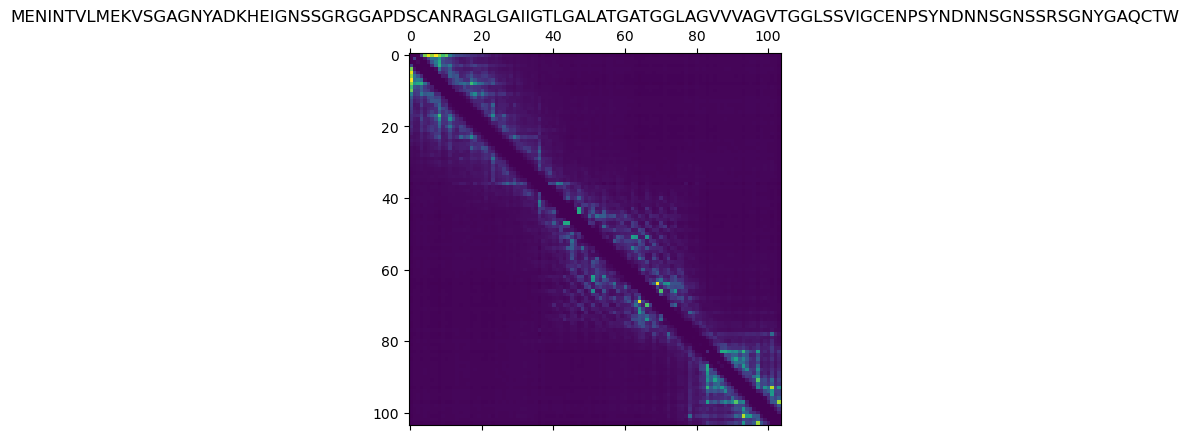

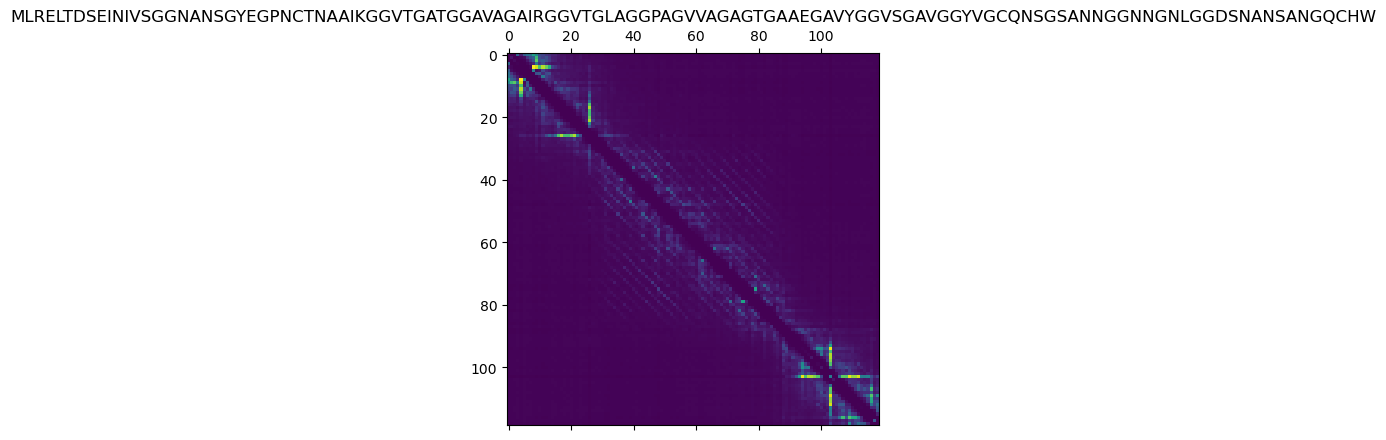

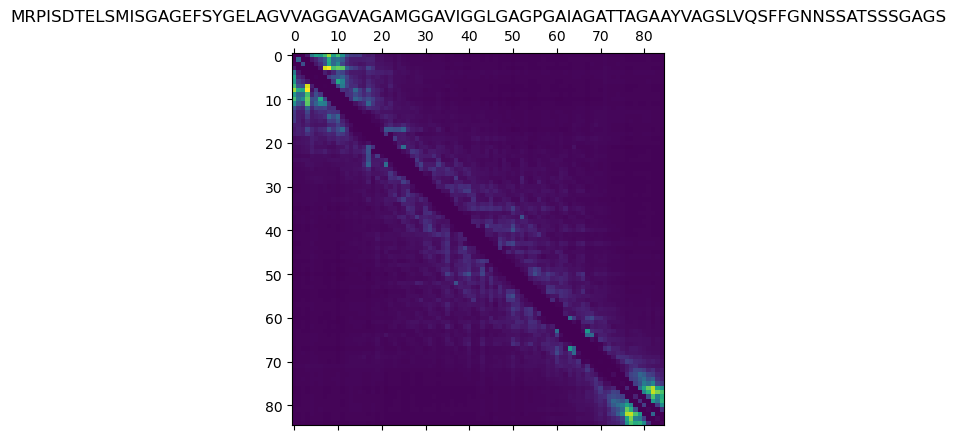

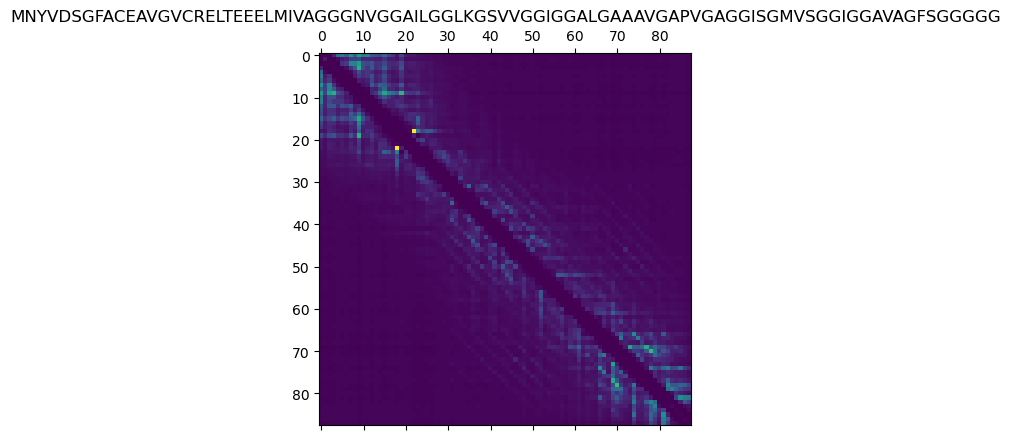

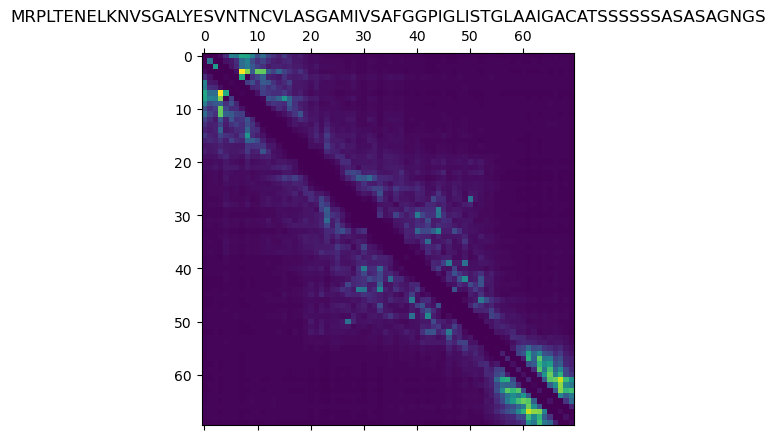

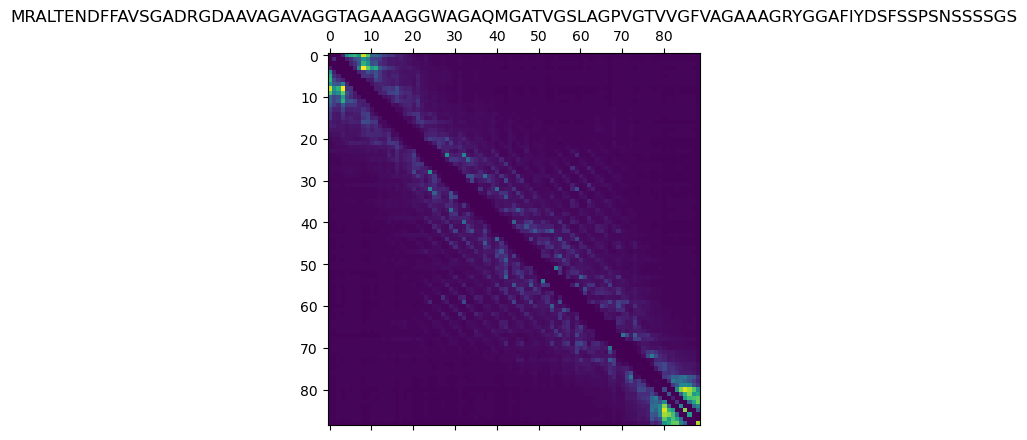

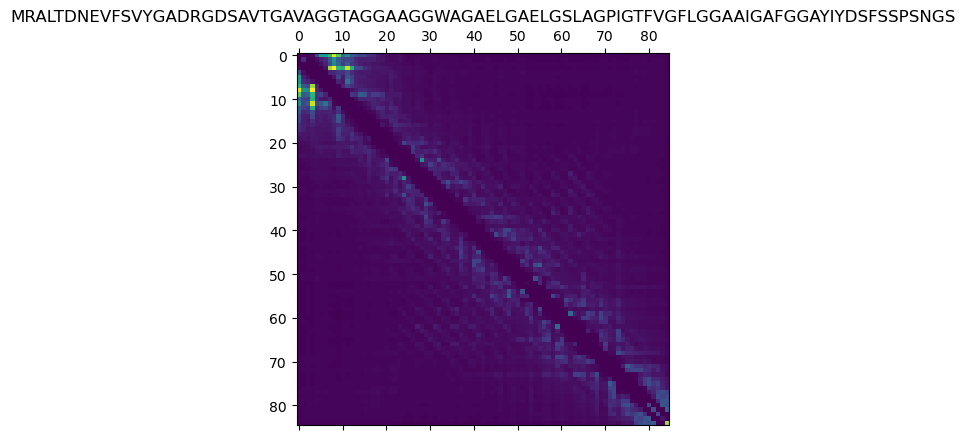

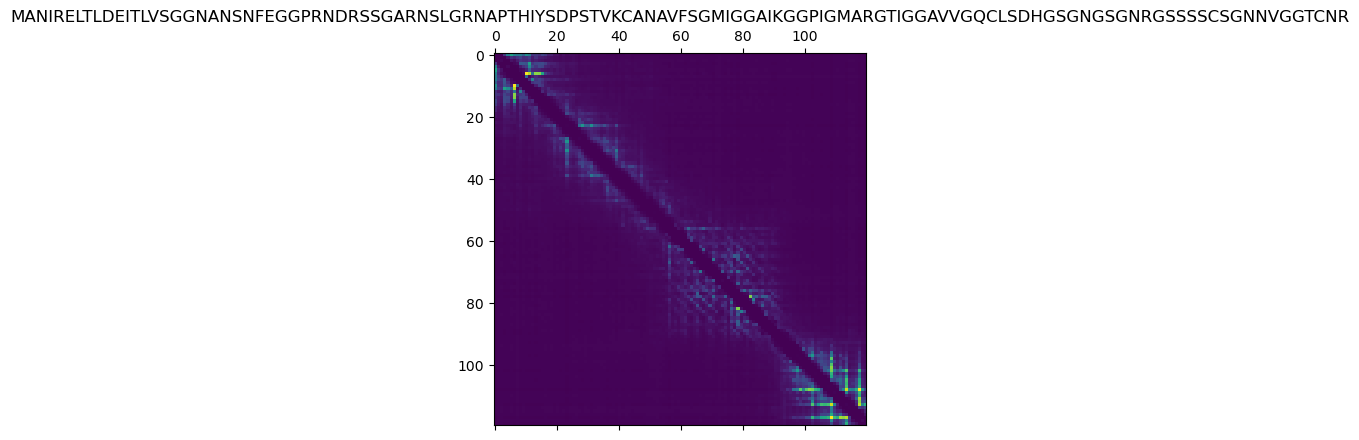

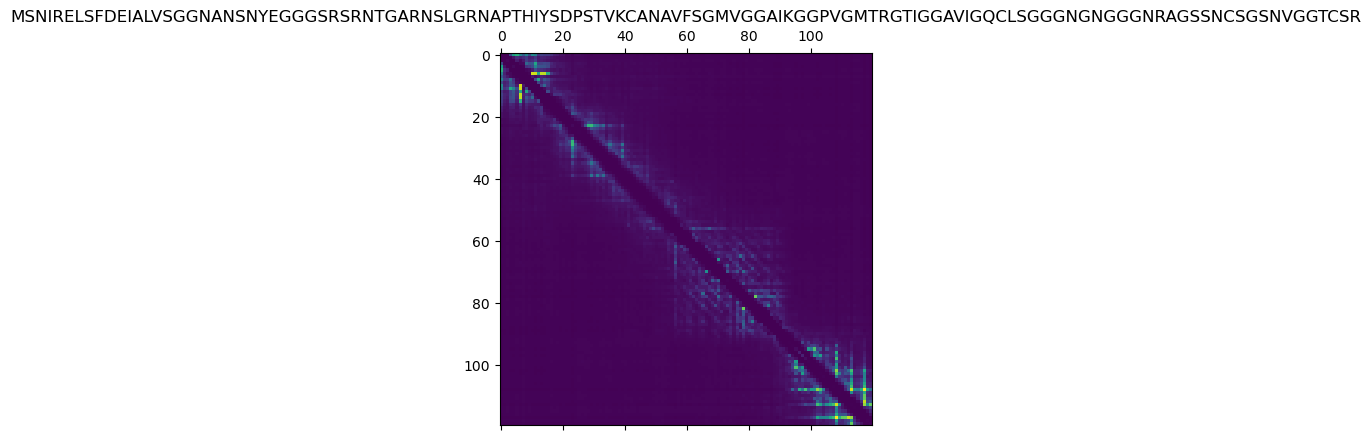

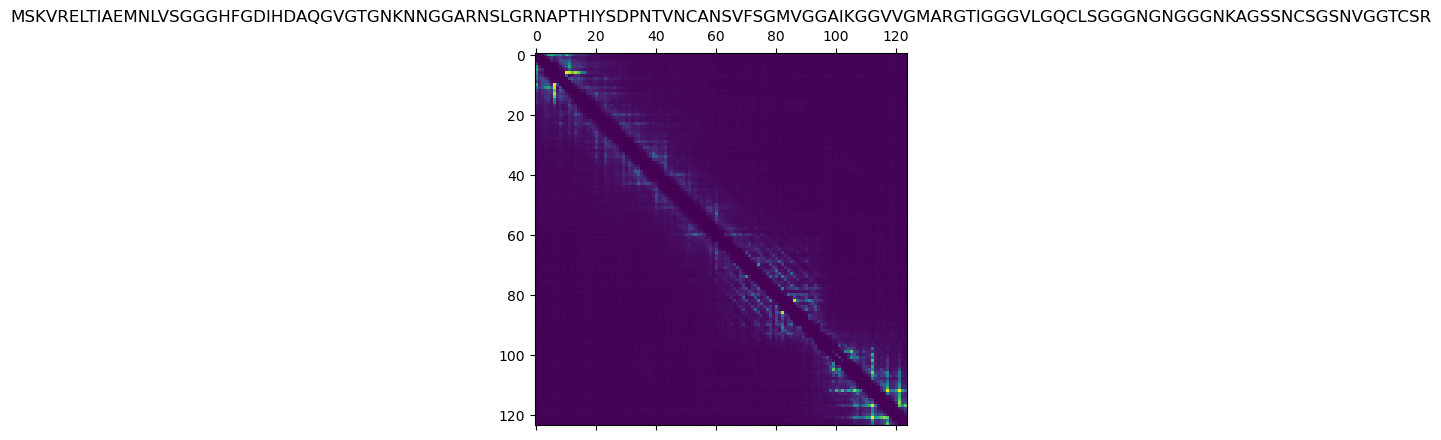

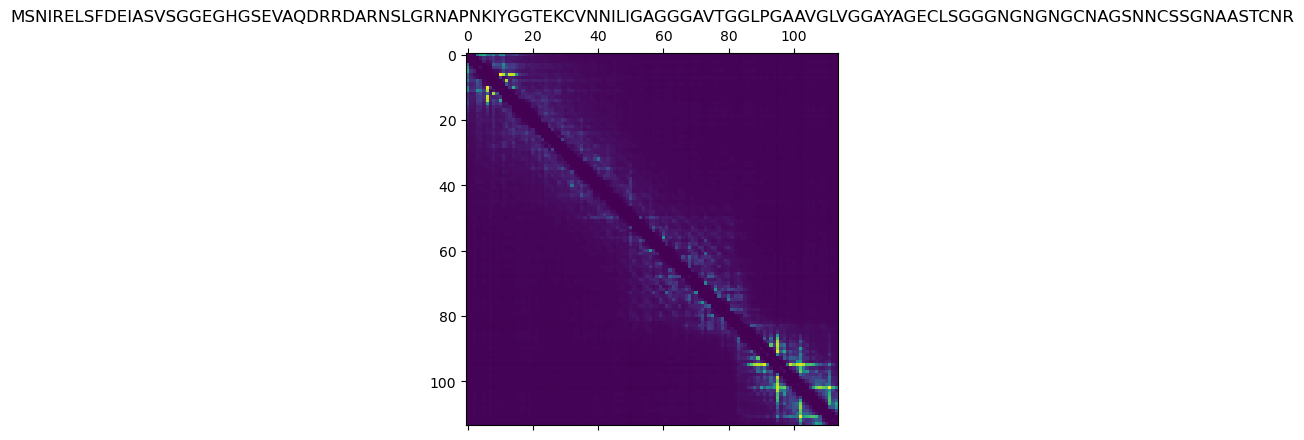

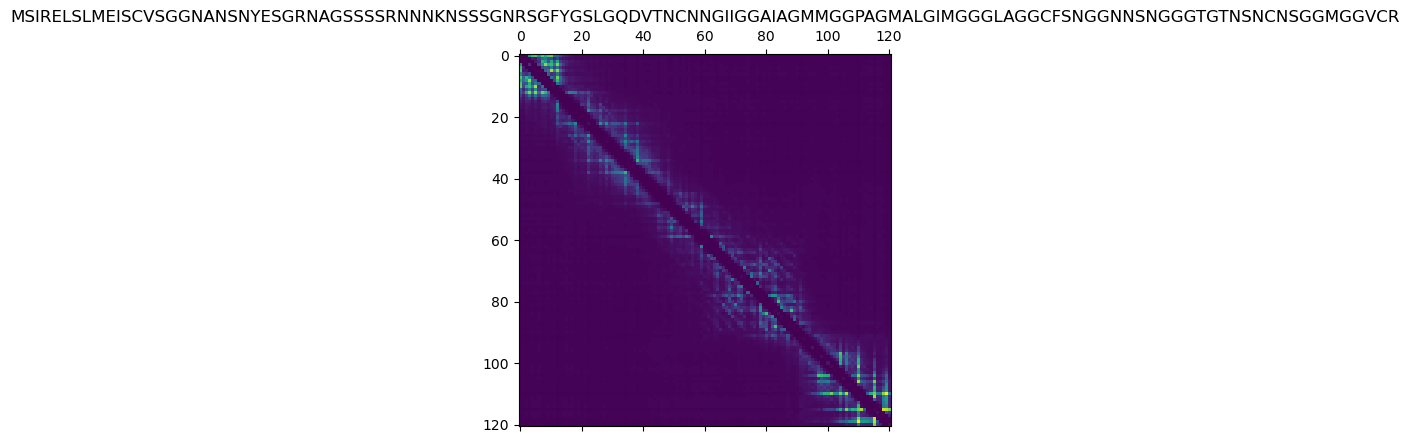

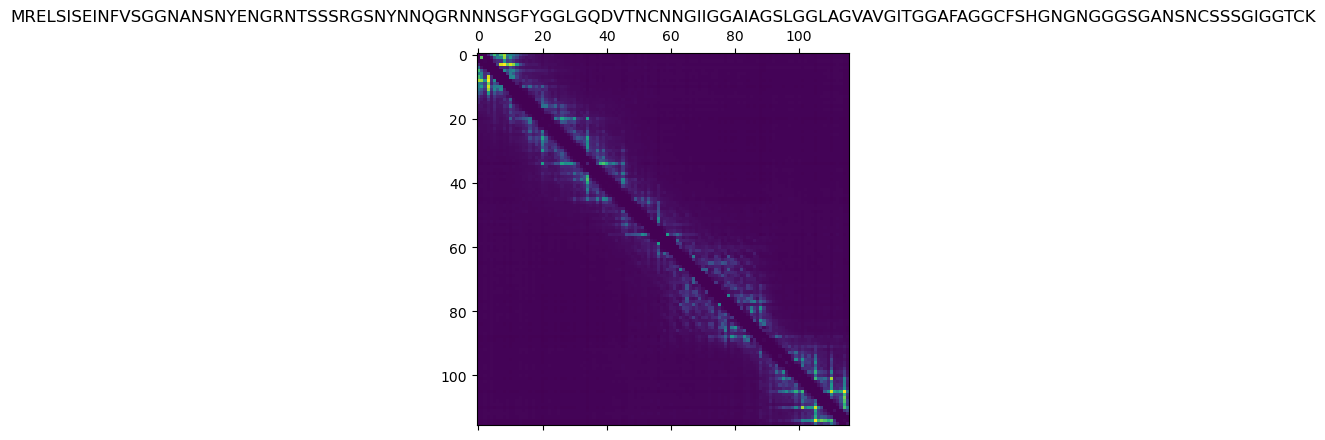

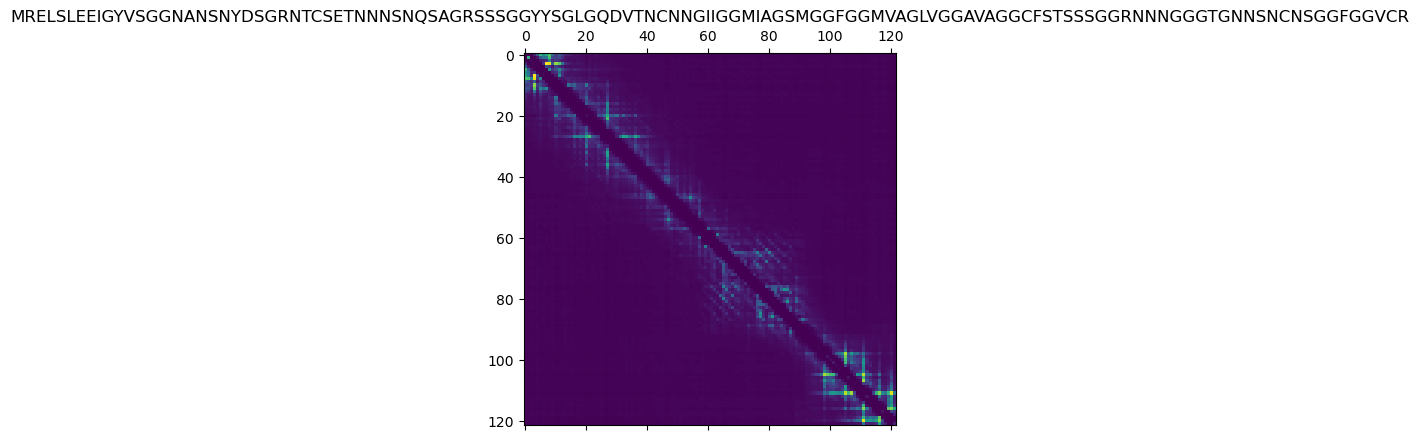

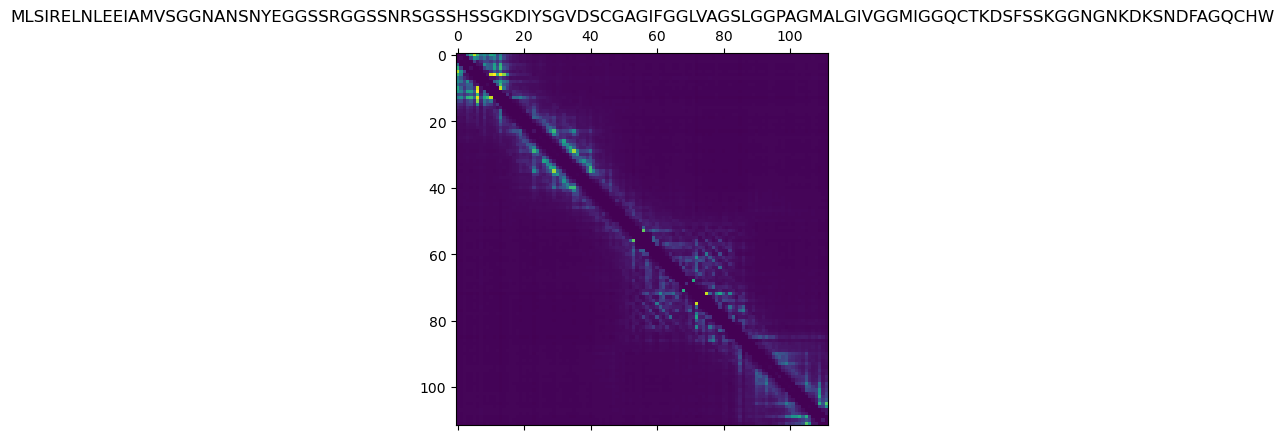

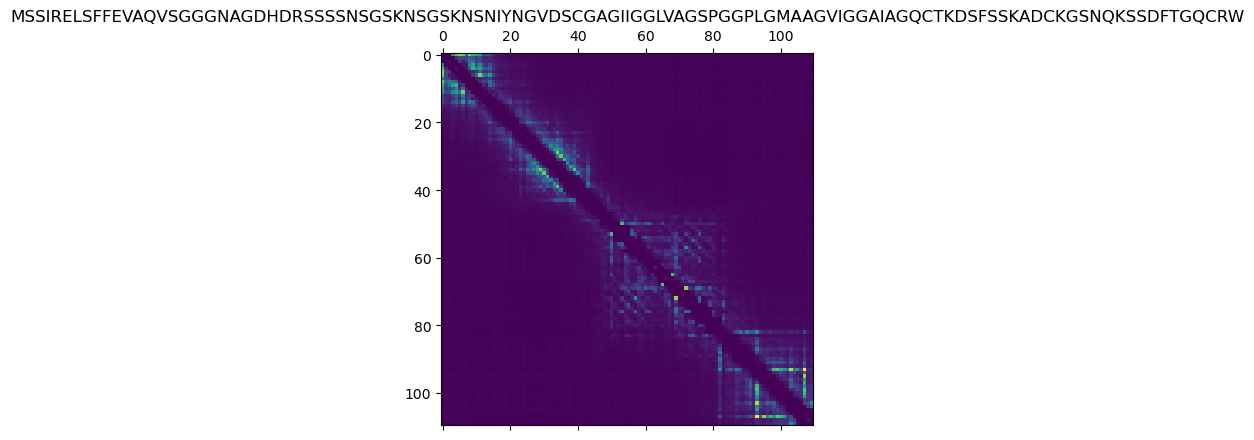

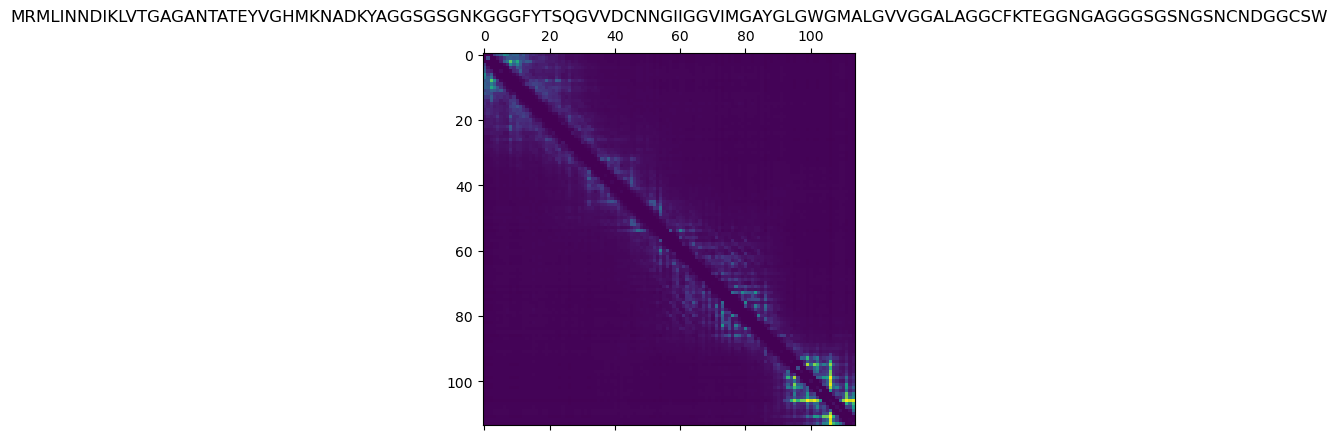

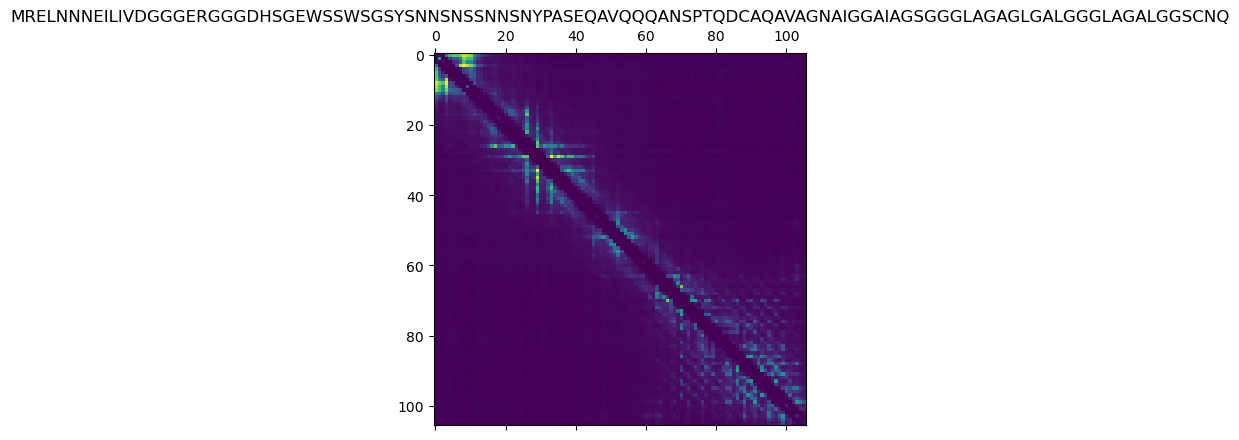

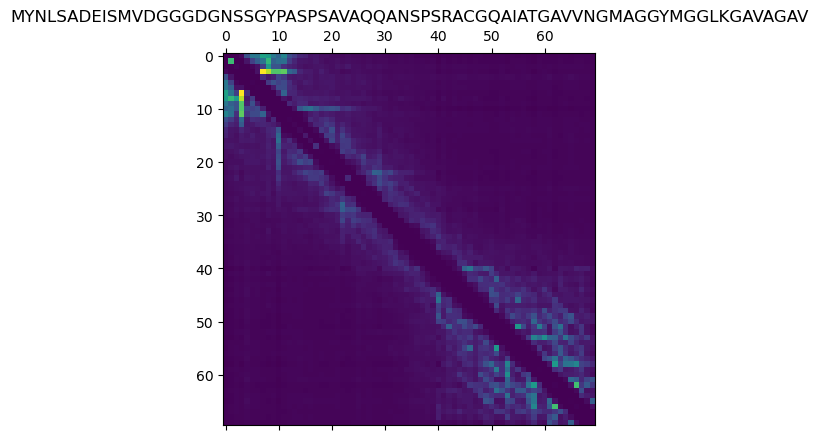

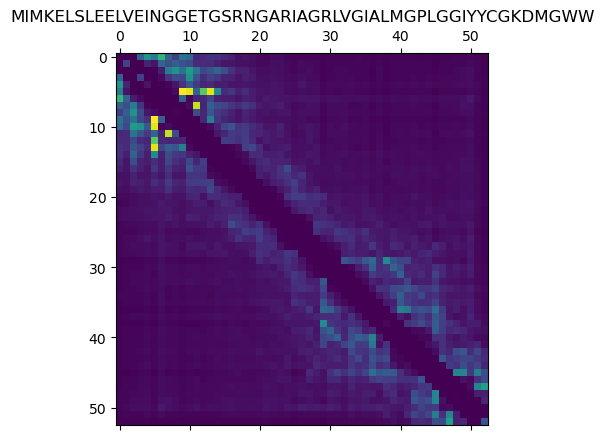

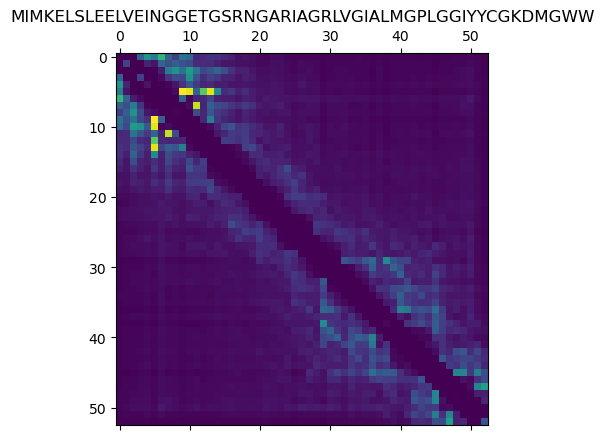

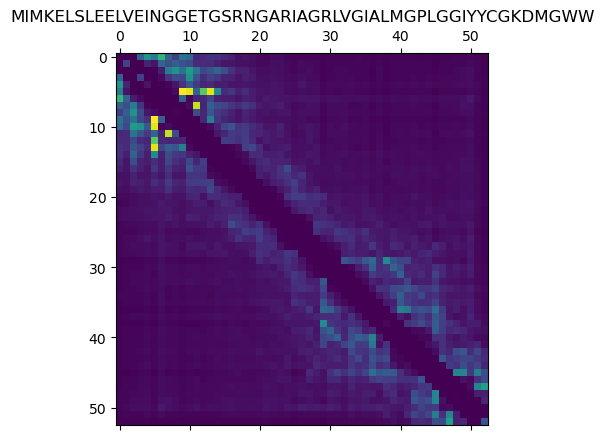

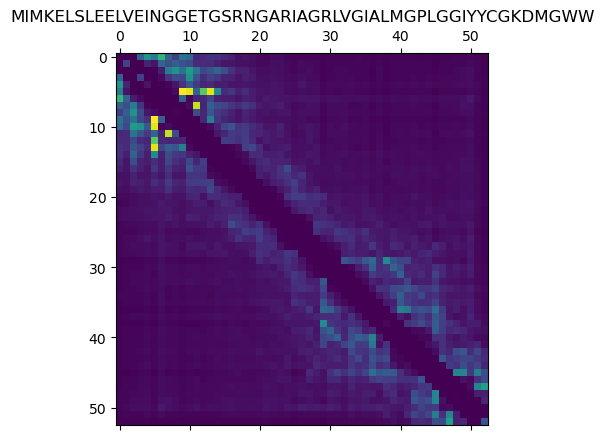

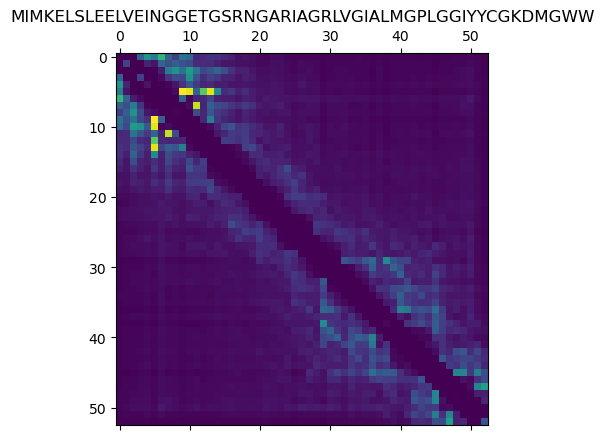

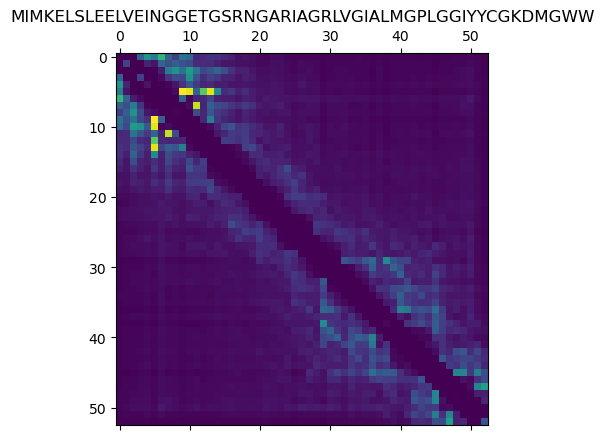

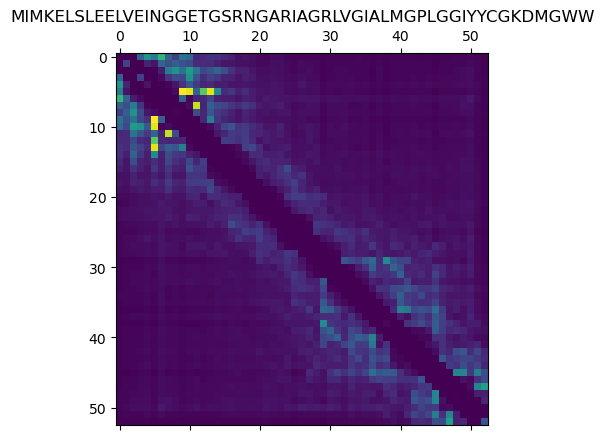

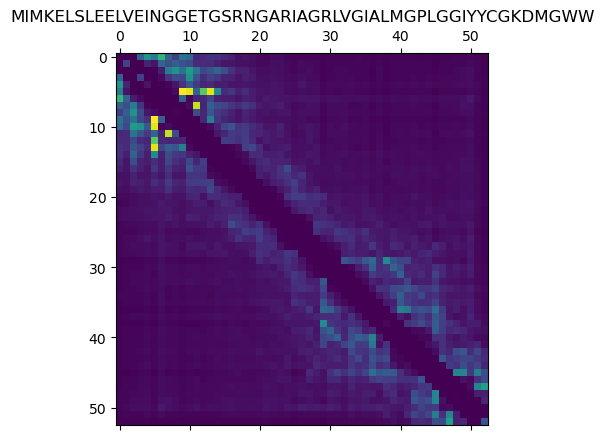

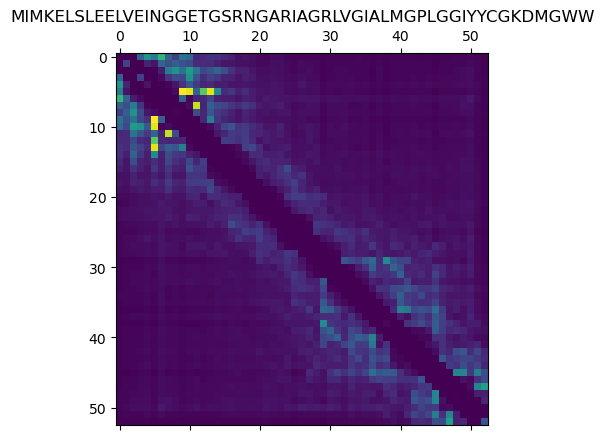

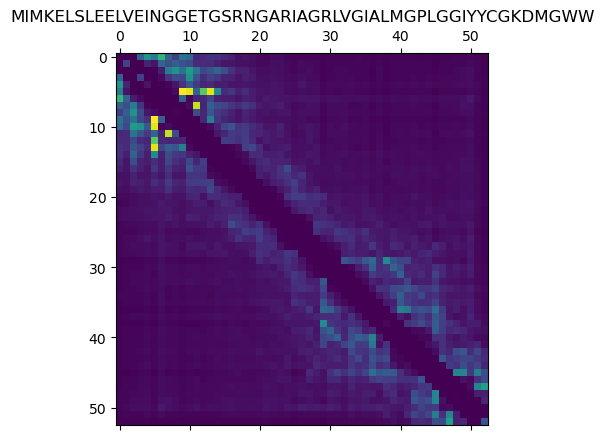

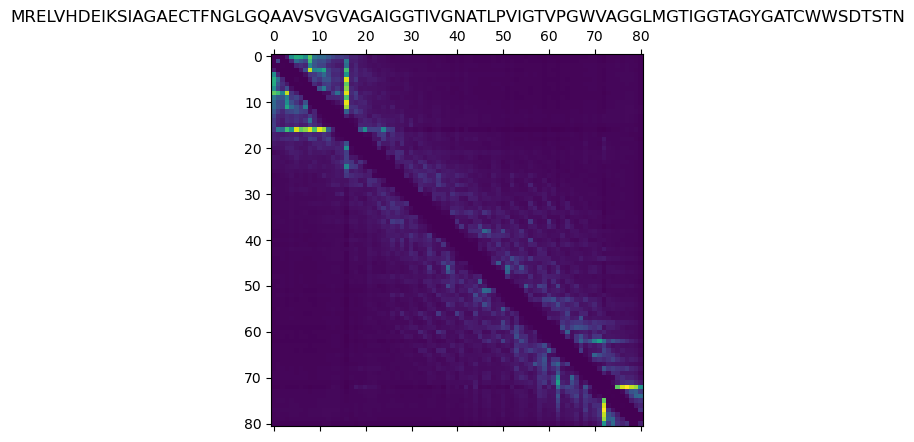

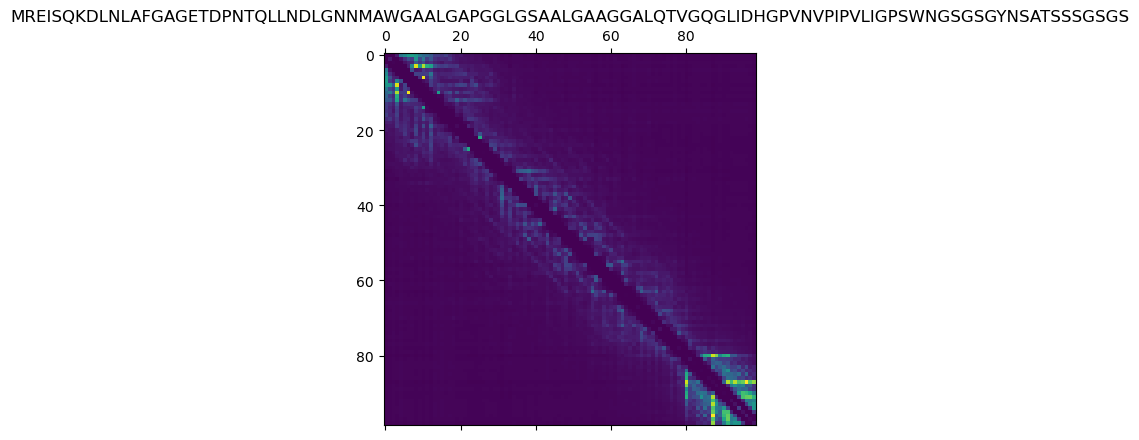

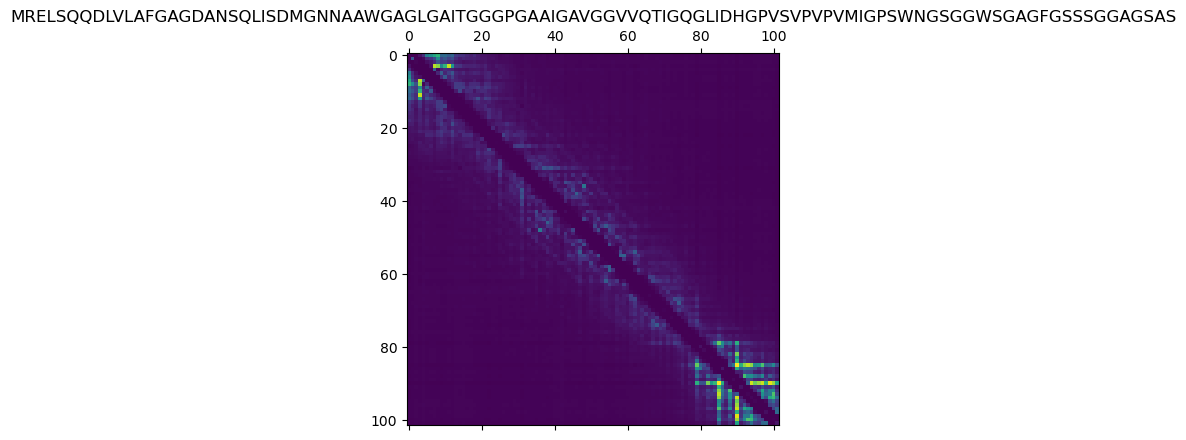

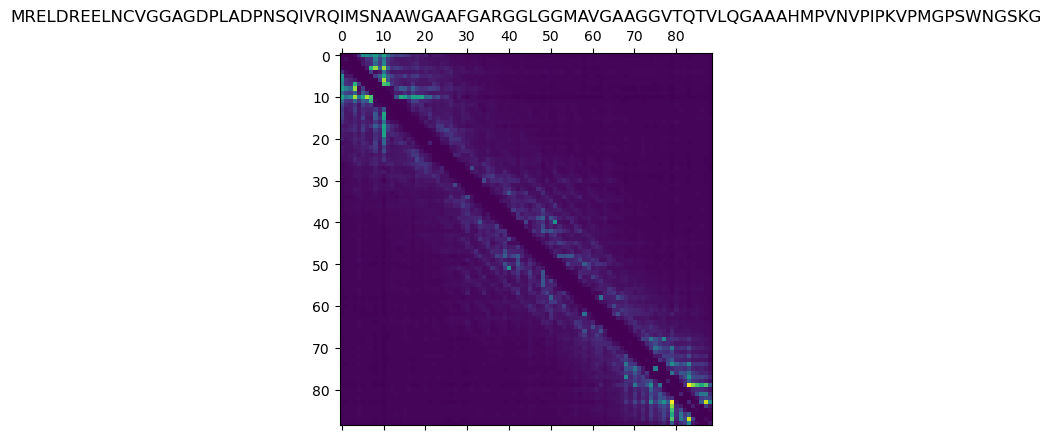

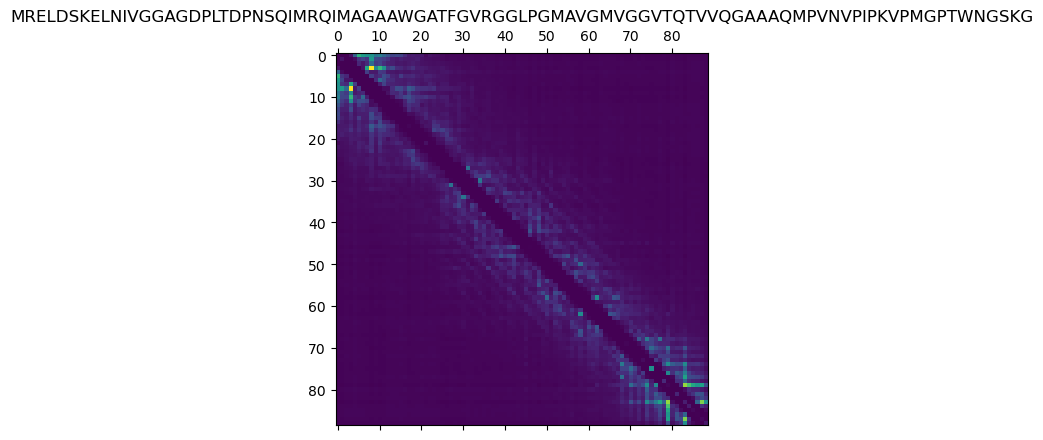

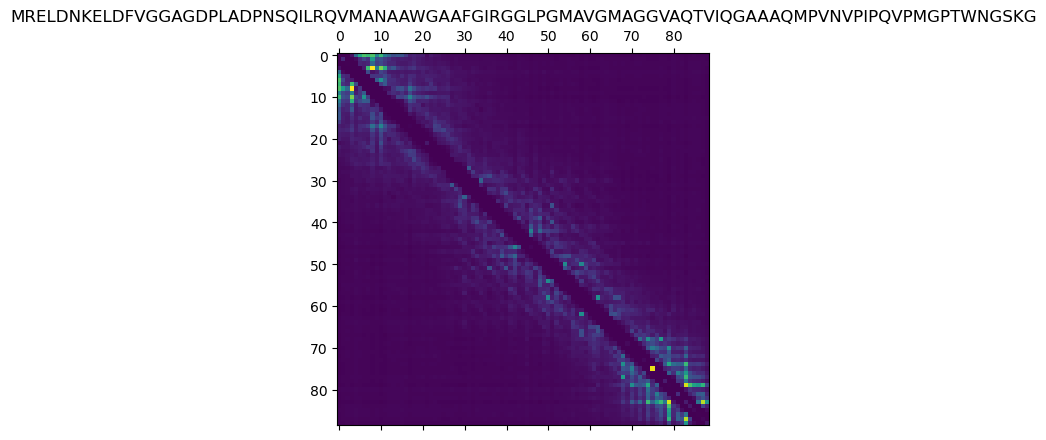

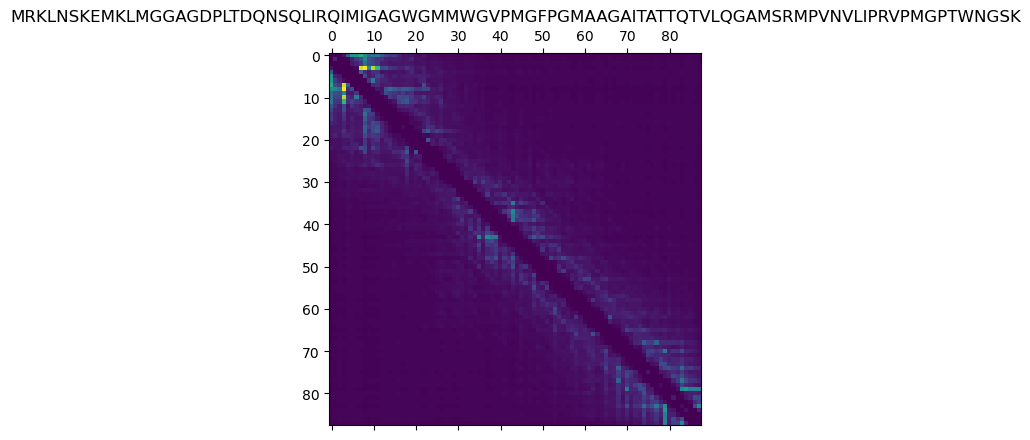

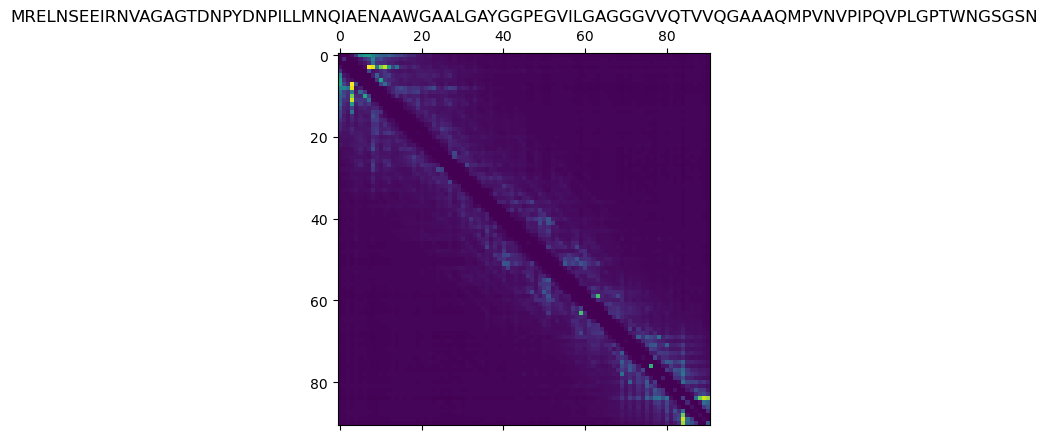

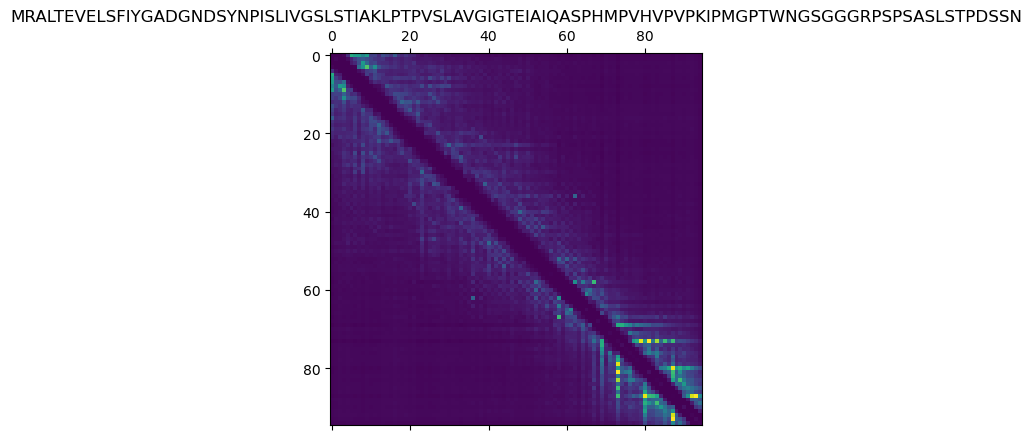

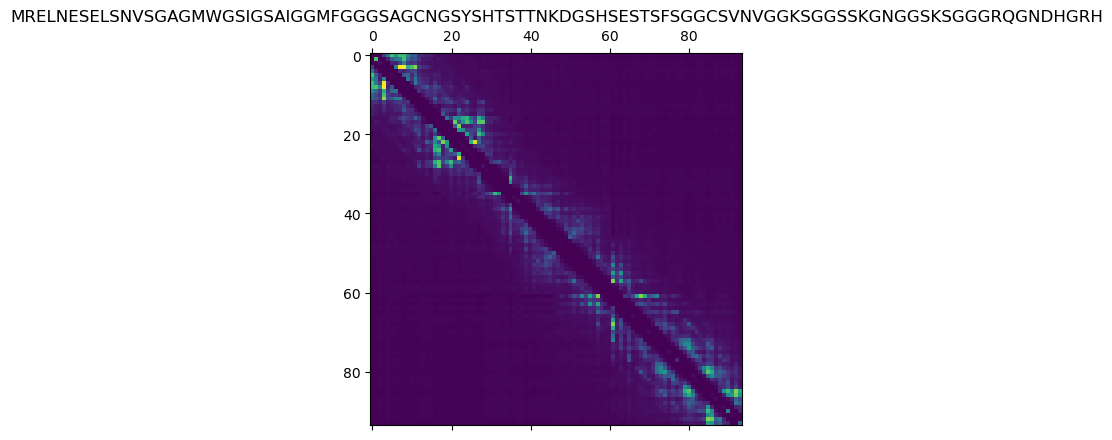

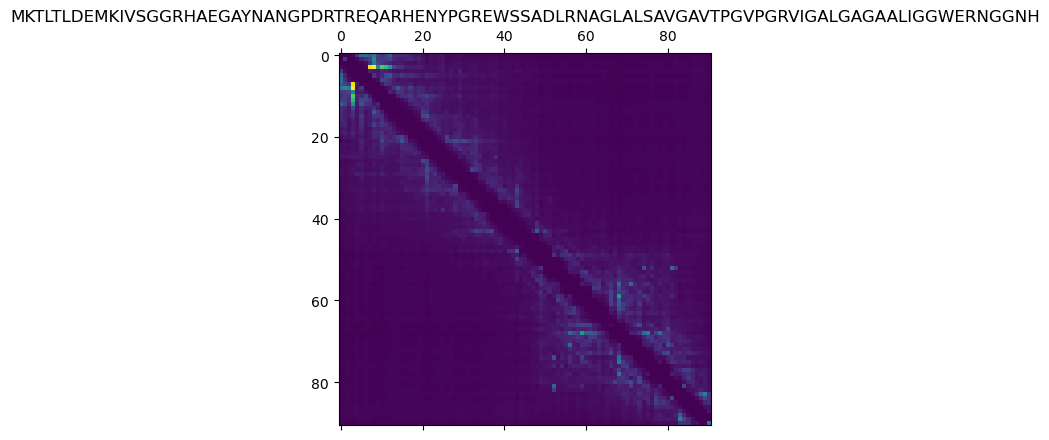

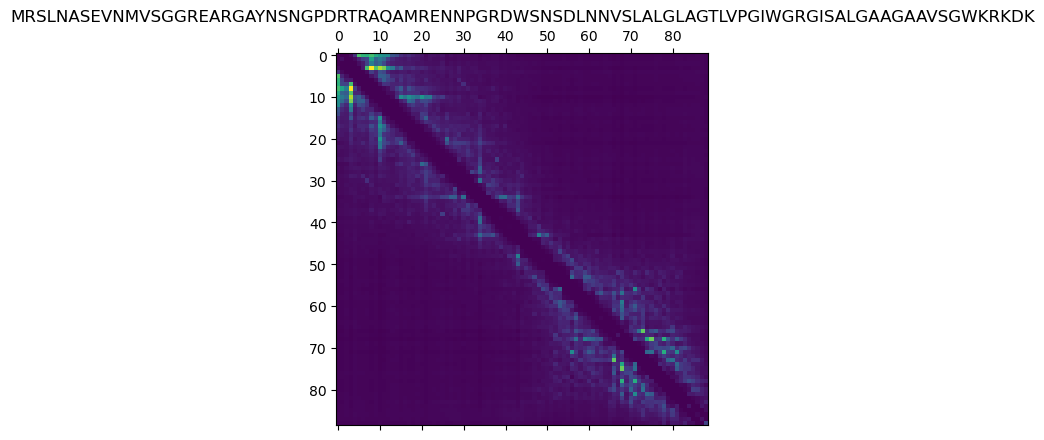

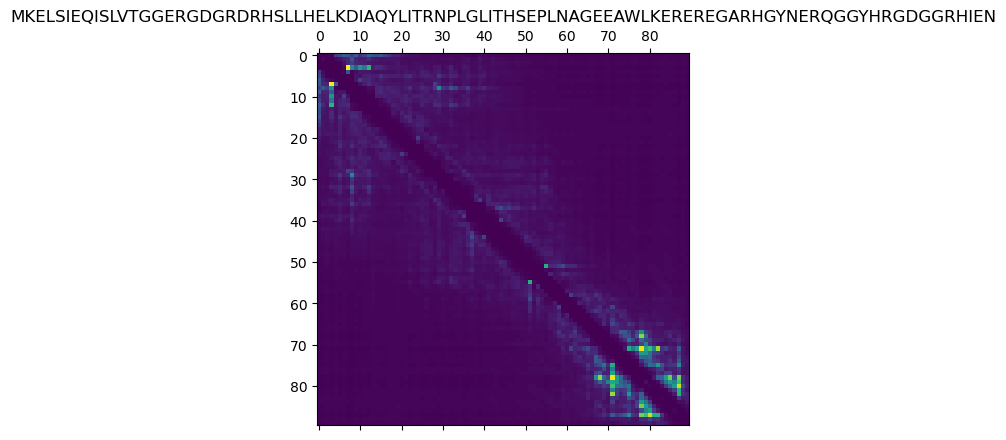

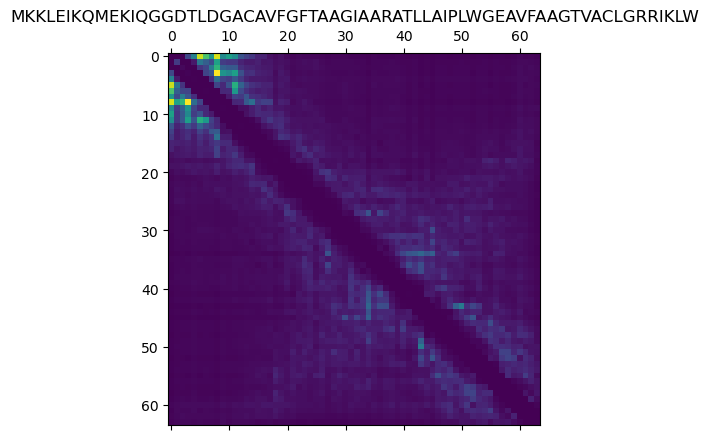

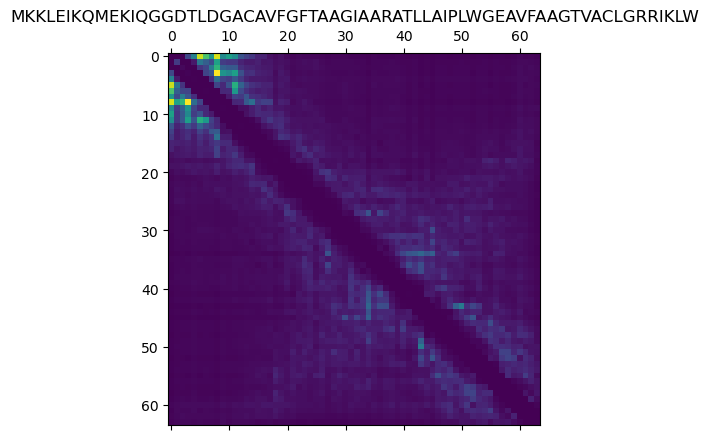

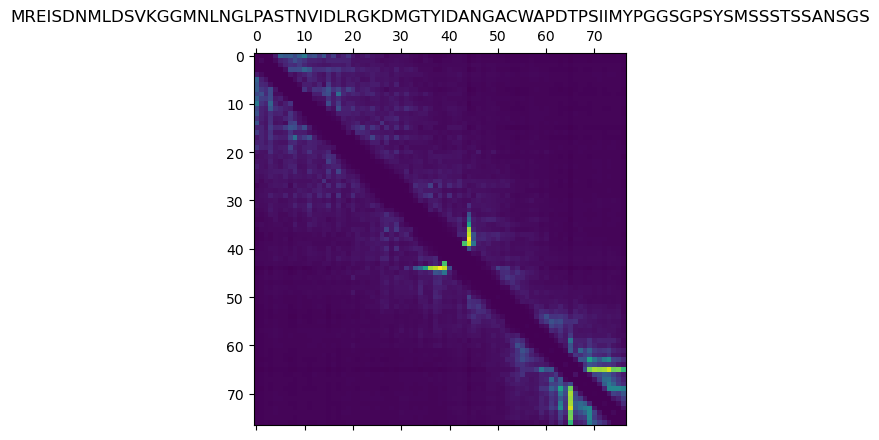

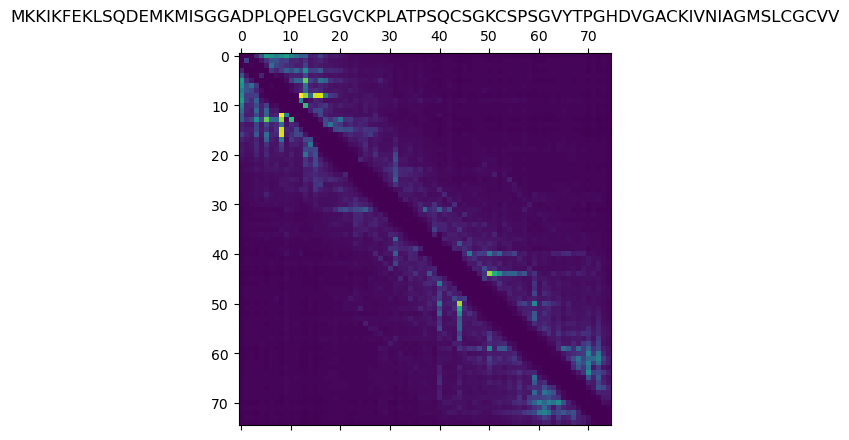

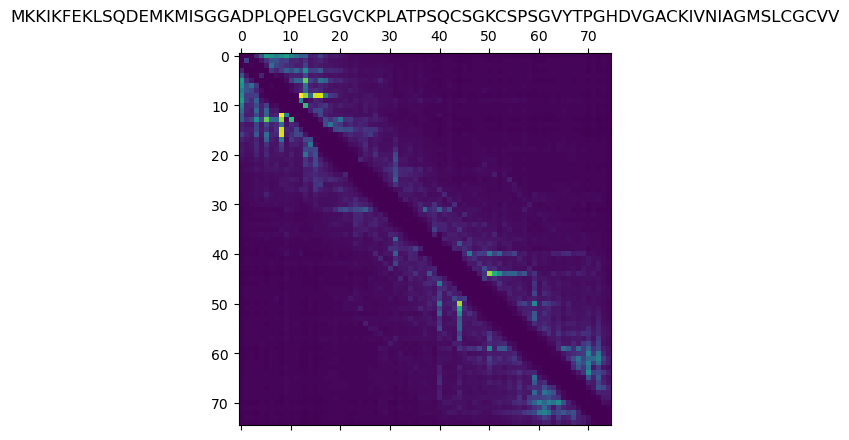

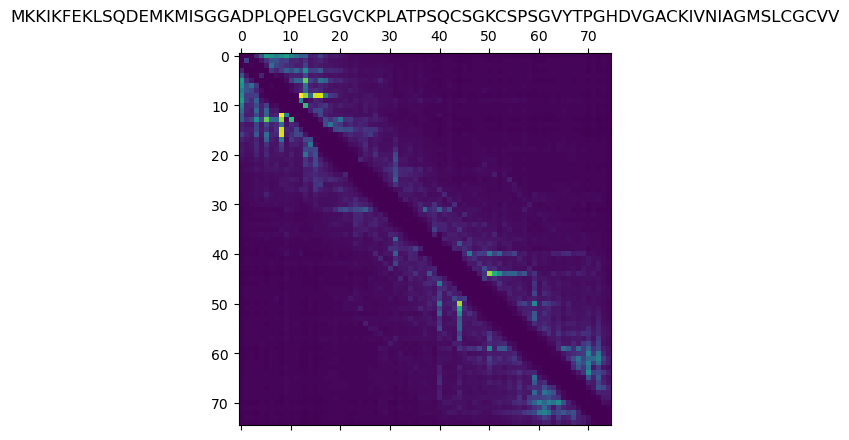

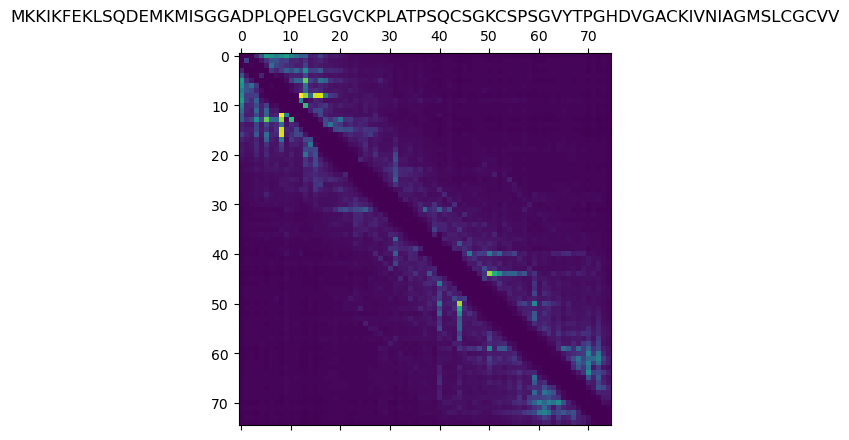

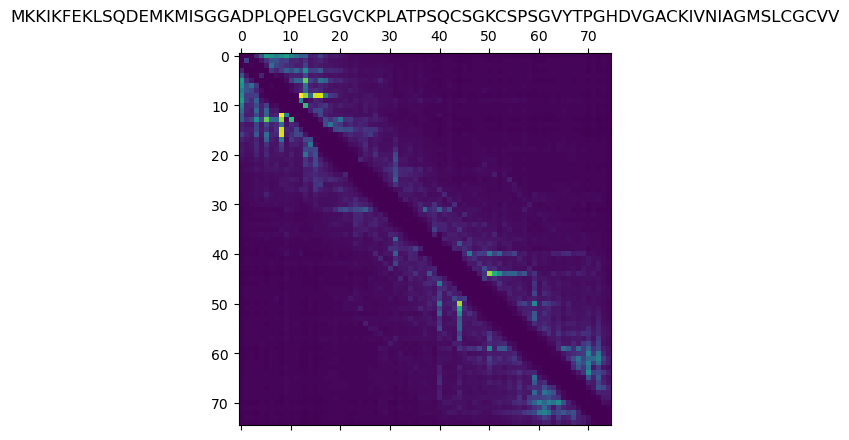

In [21]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt

for (_, seq), attention_contacts in zip(sequences[:67], results["contacts"][:67]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()